        Month      Hash  Difficulty  Addresses
0  2009-01-10  0.000003         1.0         61
1  2009-01-11  0.000005         1.0         95
2  2009-01-12  0.000005         1.0        101
3  2009-01-13  0.000006         1.0        123
4  2009-01-14  0.000006         1.0        133
object
float64
ADF Statistic: -9.114836
p-value: 0.000000
count    2515.000000
mean        0.010333
std         0.177669
min        -2.463054
25%        -0.069732
50%         0.007273
75%         0.088570
max         2.861402
Name: Hash, dtype: float64
count    2515.000000
mean        0.002435
std         0.120149
min        -0.497748
25%        -0.077260
50%         0.000000
75%         0.080291
max         0.594301
Name: Hash, dtype: float64
*******************************
count           2515
unique          2515
top       2009-01-11
freq               1
Name: Month, dtype: object
count           2515
unique          2515
top       2015-12-01
freq               1
Name: Month, dtype: object
Performing stepw

/Users/antonio_ortiz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5352.295, Time=0.48 sec


/Users/antonio_ortiz/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5714.775, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4687.412, Time=0.22 sec
 ARIMA(9,1,10)(0,0,0)[0] intercept   : AIC=-5799.679, Time=19.50 sec
 ARIMA(8,1,10)(0,0,0)[0] intercept   : AIC=-5788.651, Time=19.36 sec
 ARIMA(9,1,9)(0,0,0)[0] intercept   : AIC=-5801.439, Time=20.84 sec
 ARIMA(8,1,9)(0,0,0)[0] intercept   : AIC=-5781.630, Time=17.26 sec
 ARIMA(9,1,8)(0,0,0)[0] intercept   : AIC=-5781.973, Time=14.86 sec
 ARIMA(10,1,9)(0,0,0)[0] intercept   : AIC=-5784.706, Time=20.39 sec
 ARIMA(8,1,8)(0,0,0)[0] intercept   : AIC=-5794.802, Time=14.05 sec
 ARIMA(10,1,8)(0,0,0)[0] intercept   : AIC=-5762.826, Time=18.65 sec
 ARIMA(9,1,9)(0,0,0)[0]             : AIC=-5745.113, Time=9.87 sec

Best model:  ARIMA(9,1,9)(0,0,0)[0] intercept
Total fit time: 177.521 seconds
<bound method NDFrame.head of            Month      Hash
1     2009-01-11  0.421726
2     2009-01-12  0.010695
3     2009-01-13  0.268890
4     2009-01-14  0.047628
5     2

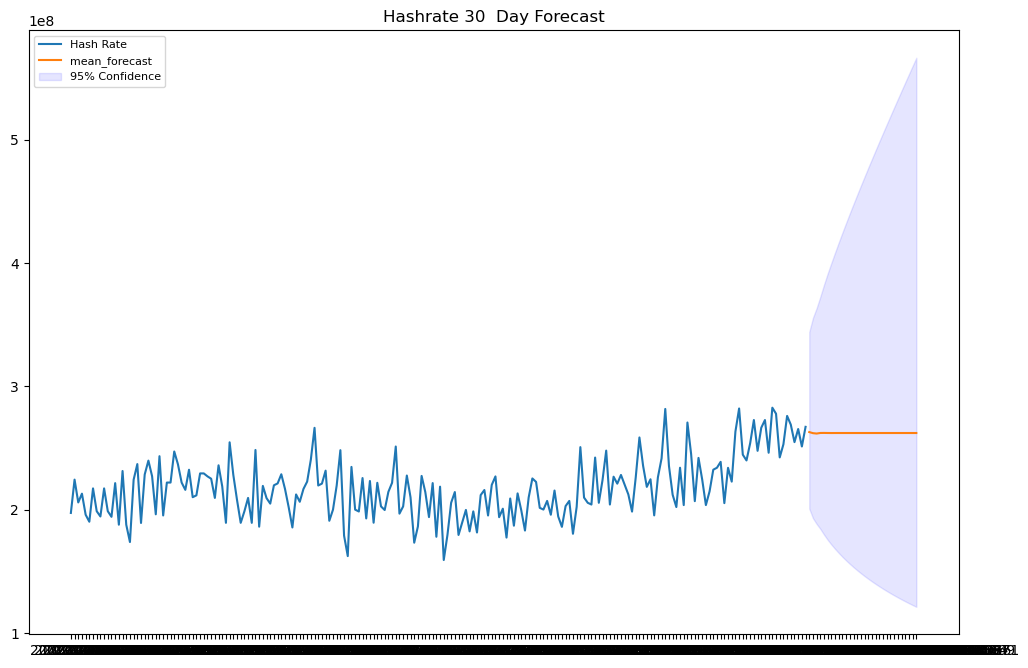

end


In [7]:
#https://towardsdatascience.com/efficient-time-series-using-pythons-pmdarima-library-f6825407b7f0

import pandas as pd
import pmdarima as pm
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm



#### VALUES:

#Number of Historical Days to Show on Chart:
numDays = 200

#Number of days to model out:
modelDays = 30



df=pd.read_csv('./testLong.csv')

df['Hash'] = df['Hash'].astype(float)


print (df.head())

#df['Month'] = pd.to_datetime(df['Month'])
#df['Month'] = df['Month'].dt.date

orig_df = df.copy()

df['Hash'] = np.log(df['Hash'])

print (df['Month'].dtypes)
print (df['Hash'].dtypes)

#fig, ax = plt.subplots(figsize=(12, 8), dpi = 100)
#ax.plot(df['Month'], df['Hash'])
#plt.show()


def adf_test(target_series):
    """
    Parameters
    ----------
    target_series : Pandas Series
        The column of dataframe that contains the target data to which
        we want to test for stationarity e.g. Bitcoin Price.
    Returns
    -------
    adf_statistic : Float
        The adf statistic.
    p_value : Float
        The p value of the adf test.
    """
    result = adfuller(target_series)
    adf_statistic = result[0]
    p_value = result[1]
    print('ADF Statistic: %f' % adf_statistic)
    print('p-value: %f' % p_value)
    return adf_statistic, p_value


def kpss_test(target_series):
    print("Results of KPSS Test:")
    kpsstest = kpss(target_series, regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


#adf_statistic, p_value = adf_test(df['Hash'])
#kpss_test(df['Hash'])



def find_order_of_differencing(p_value, df):
    """
    Parameters
    ----------
    df : DataFrame
        cleaned time series data of the respective currency.
    Returns
    -------
    d : INT
        An integar representing the number of differences to get time
        series stationary. When P value is < 0.05 from augmented
        dicky fuller test function will return d.
    """
    # get the adf statistic and p values

    adf_statistic, p_value = adf_test(df['Hash'])
    # get kpss statiostic and p value
    kpss_test(df['Hash'])
    # p value needs to be < 0.05 for time series to be stationary
    if p_value > 0.05:
        # set number of differences to 0
        d = 0
        # if p value is above threshold repeatedly run logic until below
        while p_value > 0.05:
            print("")
            print ("**********")
            print("")
            print("P value to large, trying differencing")
            # difference the time series
            df['Hash'] = df['Hash'].diff()
            # drop the null values
            df.dropna(inplace = True)
            # add 1 to d for each iteration to represent 1 differencing
            d += 1
            # perform adf test again to asses p value and exit loop if stationary
            adf_statistic, p_value = adf_test(df['Hash'])
            # perform KPSS test
            kpss_test(df['Hash'])
        print(f"Success... TS now stationary after {d} differncing")
        return d
  
#df = find_order_of_differencing(p_value, df)    

#kpss_test(df['Hash'])

df['Hash'] = df['Hash'].diff()
# drop the null values
df.dropna(inplace = True)

adf_statistic, p_value = adf_test(df['Hash'])

#fig, ax = plt.subplots(figsize=(12, 8), dpi = 100)
#ax.plot(df['Month'], df['Hash'])
#plt.show()

# create acf
#fig, ax = plt.subplots(1, figsize=(12,8), dpi=100)
#plot_acf(df['Hash'], lags=20, ax = ax)
#plt.ylim([-0.05, 0.25])
#plt.yticks(np.arange(-0.10,1.1, 0.1))
#plt.show()
# create  pacf
#fig, ax = plt.subplots(1, figsize=(12,8), dpi=100)
#plot_pacf(df['Hash'], lags = 20, ax = ax)
#plt.ylim([-0.05, 0.25])
#plt.yticks(np.arange(-0.10,1.1, 0.1))
#plt.show()


first_half = int(len(df)/2)
# Get summary for first half
print(df['Hash'][:first_half].describe())
# get summary for second half
print(df['Hash'][first_half:].describe())

print ("*******************************")

first_half = int(len(df)/2)
# Get summary for first half
print(df['Month'][:first_half].describe())
# get summary for second half
print(df['Month'][first_half:].describe())


def auto_arima(orig_df):
    """
    Parameters
    ----------
    orig_df : Data Frame
        Copied data frame from origonal read in prior to manual differencing.
    Returns
    -------
    model.order: Tuple
        tuple of found p,q,q values from auto arima
    differenced_by_auto_arima: Data Frame
        the differenced data frame output from the auto arima function
    fitted_residuals: The residuals of the fitted model.
    """
    #get target series
    orig_df = np.log(orig_df['Hash'])
    model = pm.auto_arima(orig_df,
                          start_p=10,
                          start_q=10,
                          test='adf',
                          max_p=10, 
                          max_q=10, 
                          m=1,
                          d=None,           
                          seasonal=False,   
                          D=0, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True,
                         stepwise = True)
    # difference df by d found by auto arima
    differenced_by_auto_arima = orig_df.diff(model.order[1])
    return model.order, differenced_by_auto_arima, model.resid()


model_order, differenced_data, model_residuals = auto_arima(orig_df)



df = df.drop('Addresses', axis=1)
df = df.drop('Difficulty', axis=1)

#df = pd.get_dummies(df, columns=['Month'], drop_first=True)

print (df.head)



model = sm.tsa.arima.ARIMA(np.log(orig_df['Hash']), order = (3, 1, 1))


fitted = model.fit()


    
fc = fitted.get_forecast(modelDays) 
#Set confidence to 95% 
fc = (fc.summary_frame(alpha=0.05))
#Get mean forecast
fc_mean = fc['mean']
#Get lower confidence forecast
fc_lower = fc['mean_ci_lower']
#Get upper confidence forecast
fc_upper = fc['mean_ci_upper'] 
#Set figure size
plt.figure(figsize=(12,8), dpi=100)
#Plot last 50 price movements
plt.plot(orig_df['Month'][-numDays:],orig_df['Hash'][-numDays:], label='Hash Rate')
# create date axis for predictions
future_7_days =  [str(datetime.datetime.today() + datetime.timedelta(days=x)) for x in range(modelDays)]
#Plot mean forecas
plt.plot(future_7_days, np.exp(fc_mean), label='mean_forecast', linewidth = 1.5)
#Create confidence interval
plt.fill_between(future_7_days, np.exp(fc_lower),np.exp(fc_upper), color='b', alpha=.1, label = '95% Confidence')
#Set title
plt.title('Hashrate ' + str(modelDays) + '  Day Forecast')
#Set legend
plt.legend(loc='upper left', fontsize=8)
plt.show()

print ("end")